# Imports and setting up viz

NB : conda lam1env (Python3.12)

In [72]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
import sys
sys.path.append('../../python_tools/')
from tools import *
from tools_mapping import *
from tools_hf import *
from tools_native import *
from tools_LIAISE import *

# sys.path.append('../../python_tools/aborella/PLOTS/')
# from datasets import *
sys.path.append('../../python_tools/aborella/UTIL/')
import xr_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
psy.rcParams['auto_show'] = True
mpl.rcParams['figure.figsize'] = [10., 8.]

# Load model files and edit datasets

LAM output analysis.

Simu irr et simu no-irr.

In [3]:
# nat_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/hourly_native'
nat_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/halfhour_native'

rough_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/roughdyn_z0ratios'
boost_irrig_dir= '../../../JZ_simu_outputs/LAM/LAM_1500_60/boost_irrig'
change_pft_dir= '../../../JZ_simu_outputs/LAM/LAM_1500_60/change_pft'

## LMDZ

In [4]:
def format_lmdz_HF(filename, color, name):
    ds = xr.open_mfdataset(filename)
    ds = ds.rename({'time_counter':'time'})
    ds = ds.assign_coords(time_decimal=ds.time.dt.hour + ds.time.dt.minute / 60)
    ds.attrs['name'] = name
    ds.attrs['plot_color']=color

    ds['sens']=-ds['sens']
    ds['flat']=-ds['flat']

    ds['ground_level'] = ds['phis'] / 9.81
    ds['ground_level'].attrs['units'] = 'm'

    ds=add_wind_speed(ds)
    ds=add_wind_direction(ds)
    ds=add_wind_10m(ds)
    # ds=add_relative_humidity(ds)

    #make ovap unit g/kg
    ds['ovap'] = ds['ovap']*1000
    ds['ovap'].attrs['units'] = 'g/kg'
    ds['ovap'].attrs['long_name'] = 'Specific humidity'
    #same for q2m
    ds['q2m'] = ds['q2m']*1000
    ds['q2m'].attrs['units'] = 'g/kg'
    #turn psol to hPa
    ds['psol'] = ds['psol']/100
    ds['psol'].attrs['units'] = 'hPa'
    #make precip unit mm/30mn (like obs)
    ds['precip']=ds['precip'] * 60 * 30
    ds['precip'].attrs['long_name'] = 'Total precipitation'
    ds['precip'].attrs['units']='mm (over 30mn)'

    # ds['SWdn_diff'] = ds['SWdnSFCclr'] - ds['SWdnSFC']
    # ds['SWdn_diff'].attrs['units'] = 'W/m2'

    if 'rsds' in ds:
        rename_dict2={'rsds':'SWdnSFC',
                      'rlds':'LWdnSFC'}
        ds=ds.rename(rename_dict2)
        #add units
        ds['SWdnSFC'].attrs['units'] = 'W/m2'
        ds['LWdnSFC'].attrs['units'] = 'W/m2'

    # ds = compute_grid_cell_width(ds)
    # ds = add_moisture_divergence(ds)
    ds['q_transport'] = ( ds['uq'] + ds['vq'] )
    ds['q_transport'].attrs['units'] = '-'
    ds['q_transport'].attrs['long_name'] = 'Moisture transport'
    
    return ds

In [5]:
lmdz_noirr_file = '{}/sim267_20210701_20210731_HF_histhf.nc'.format(nat_dir)
lmdz_noirr = format_lmdz_HF(lmdz_noirr_file, 'red', 'noirr')
lmdz_noirr

<xarray.Dataset> Size: 46GB
Dimensions:               (cell: 9241, nvertex: 6, presnivs: 79, time: 1488,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    lon                   (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
  * presnivs              (presnivs) float32 316B 1.012e+05 1.009e+05 ... 1.483
    time_centered         (time) datetime64[ns] 12kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 12kB 2021-07-01T00:15:00 ... ...
    time_instant          (time) datetime64[ns] 12kB dask.array<chunksize=(1,), meta=np.ndarray>
    time_decimal          (time) float64 12kB 0.25 0.75 1.25 ... 23.25 23.75
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/60)
    bounds_lon            (cell, nvertex) float32 222kB dask.array<chunksize=(9241, 6), meta=np.ndarray>
    bounds_lat            (cell, nvertex) float32 222kB dask.array<chunksize=(9241, 6), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 24kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 24kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] 24kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    phis                  (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    ...                    ...
    ground_level          (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    wind_speed            (time, presnivs, cell) float32 4GB dask.array<chunksize=(1, 79, 9241), meta=np.ndarray>
    wind_direction        (time, presnivs, cell) float32 4GB dask.array<chunksize=(1, 79, 9241), meta=np.ndarray>
    wind_speed_10m        (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    wind_direction_10m    (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    q_transport           (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
Attributes:
    name:         noirr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Mar-12 15:55:58 GMT
    uuid:         ee437f44-3a58-4d21-ba9a-01fe07f3a02a
    plot_color:   red

In [6]:
lmdz_irr_file = '{}/sim268_20210701_20210731_HF_histhf.nc'.format(nat_dir)
lmdz_irr = format_lmdz_HF(lmdz_irr_file, 'blue', 'irr')
# lmdz_irr

## ORCHIDEE

In [7]:
def format_ORC_HF(filename, color, name):
    ds = xr.open_mfdataset(filename)
    ds = ds.rename({'time_counter':'time',})
    ds = ds.assign_coords(time_decimal=ds.time.dt.hour + ds.time.dt.minute / 60)
    ds.attrs['name'] = name
    ds.attrs['plot_color']= color
    # ds = ds.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

    ds['evapot']=ds['evapot'] * 3600 * 24
    ds['evapot'].attrs['units'] = 'mm/d'

    ds['evapot_corr']=ds['evapot_corr'] * 3600 * 24
    ds['evapot_corr'].attrs['units'] = 'mm/d'

    ds['flat'] = ds['evap'] /  (0.408 * 0.0864)
    ds['flat'].attrs['units'] = 'W/m2'

    ds['tran'] = ds['tran'] * 3600 * 24
    ds['tran'].attrs['units'] = 'mm/d'

    ds['inter_12'] = ds['inter'][:,11,:]
    ds['inter_12'].attrs['units'] = 'mm/d'
    ds['inter_12'].attrs['long_name'] = 'Interception for PFT12'

    ds['inter_5'] = ds['inter'][:,4,:]
    ds['inter_13'] = ds['inter'][:,12,:]

    if 'humtot_soil' in ds:
        ds['humtot_1'] = ds['humtot_soil'][:,0,:]
        ds['humtot_2'] = ds['humtot_soil'][:,1,:]
        ds['humtot_3'] = ds['humtot_soil'][:,2,:]
    
    ds['soil_temp_01'] = ds['ptn'][:,3,:] - 273.15
    ds['soil_temp_01'].attrs['units'] = '°C'
    ds['soil_temp_01'].attrs['long_name'] = 'Soil temperature at 1.3cm'
    ds['soil_temp_03'] = ds['ptn'][:,4,:] - 273.15
    ds['soil_temp_03'].attrs['units'] = '°C'
    ds['soil_temp_03'].attrs['long_name'] = 'Soil temperature at 2.9cm'
    ds['soil_temp_06'] = ds['ptn'][:,5,:] - 273.15
    ds['soil_temp_06'].attrs['units'] = '°C'
    ds['soil_temp_06'].attrs['long_name'] = 'Soil temperature at 6.06cm'
    ds['soil_temp_12'] = ds['ptn'][:,6,:] - 273.15
    ds['soil_temp_12'].attrs['units'] = '°C'
    ds['soil_temp_12'].attrs['long_name'] = 'Soil temperature at 12.3cm'

    if 'npp' in ds:
        ds['npp_12'] = ds['npp'][:,11,:]
        ds['npp_6'] = ds['npp'][:,5,:]
        ds['npp_13'] = ds['npp'][:,12,:]

    if 'gpp' in ds:
        ds['gpp_12'] = ds['gpp'][:,11,:]
        ds['gpp_6'] = ds['gpp'][:,5,:]
        ds['gpp_13'] = ds['gpp'][:,12,:]
    if 'lai' in ds:
        ds['lai_12'] = ds['lai'][:,11,:]
        ds['lai_6'] = ds['lai'][:,5,:]
        ds['lai_13'] = ds['lai'][:,12,:]
    # if 'maxvegetfrac' in ds:
    #     ds['maxvegetfrac_12'] = ds['maxvegetfrac'][:,11,:]
    #     ds['maxvegetfrac_6'] = ds['maxvegetfrac'][:,5,:]
    #     ds['maxvegetfrac_13'] = ds['maxvegetfrac'][:,12,:]
    return ds

In [8]:
orc_noirr_file = '{}/sim267_20210701_20210731_HF_sechiba_out_2.nc'.format(nat_dir)
orc_noirr = format_ORC_HF(orc_noirr_file, 'red', 'noirr')
orc_noirr

<xarray.Dataset> Size: 6GB
Dimensions:               (cell: 9241, nvertex: 6, veget: 15, solth: 18,
                           time: 1488, axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    lon                   (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
  * veget                 (veget) float32 60B 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * solth                 (solth) float32 72B 0.0004888 0.001955 ... 33.53 65.56
    time_centered         (time) datetime64[ns] 12kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 12kB 2021-07-01T00:15:00 ... ...
    time_decimal          (time) float64 12kB 0.25 0.75 1.25 ... 23.25 23.75
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/41)
    bounds_lon            (cell, nvertex) float32 222kB dask.array<chunksize=(9241, 6), meta=np.ndarray>
    bounds_lat            (cell, nvertex) float32 222kB dask.array<chunksize=(9241, 6), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 24kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 24kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                 (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    Contfrac              (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    ...                    ...
    soil_temp_03          (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    soil_temp_06          (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    soil_temp_12          (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    lai_12                (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    lai_6                 (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    lai_13                (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
Attributes:
    name:         noirr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Mar-12 15:55:58 GMT
    uuid:         0da80c4f-0b9a-4c5f-9d7f-abd1c2f5908a
    plot_color:   red

In [9]:
orc_irr_file =  '{}/sim268_20210701_20210731_HF_sechiba_out_2.nc'.format(nat_dir)
orc_irr = format_ORC_HF(orc_irr_file, 'blue', 'irr')
orc_irr

<xarray.Dataset> Size: 6GB
Dimensions:               (cell: 9241, nvertex: 6, veget: 15, solth: 18,
                           time: 1488, axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    lon                   (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
  * veget                 (veget) float32 60B 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * solth                 (solth) float32 72B 0.0004888 0.001955 ... 33.53 65.56
    time_centered         (time) datetime64[ns] 12kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 12kB 2021-07-01T00:15:00 ... ...
    time_decimal          (time) float64 12kB 0.25 0.75 1.25 ... 23.25 23.75
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/41)
    bounds_lon            (cell, nvertex) float32 222kB dask.array<chunksize=(9241, 6), meta=np.ndarray>
    bounds_lat            (cell, nvertex) float32 222kB dask.array<chunksize=(9241, 6), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 24kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 24kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                 (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    Contfrac              (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    ...                    ...
    soil_temp_03          (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    soil_temp_06          (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    soil_temp_12          (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    lai_12                (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    lai_6                 (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    lai_13                (time, cell) float32 55MB dask.array<chunksize=(1, 9241), meta=np.ndarray>
Attributes:
    name:         irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Mar-12 15:56:53 GMT
    uuid:         23d792f3-a907-4a28-8b98-4a26dbdc8a19
    plot_color:   blue

## Selecting subdatasets

### LIAISE sites

In [10]:
#SOP
day_start_times=[day1_start_time, day2_start_time, day3_start_time, day4_start_time, day5_start_time, day6_start_time, day7_start_time]
day_end_times  =[day1_end_time, day2_end_time, day3_end_time, day4_end_time, day5_end_time, day6_end_time, day7_end_time]

In [11]:
cen_lmdz_noirr, els_lmdz_noirr  , sop_cen_lmdz_noirr,   sop_els_lmdz_noirr = select_liaise_sites_sop(lmdz_noirr, 'no_irr')
cen_lmdz_irr, els_lmdz_irr      , sop_cen_lmdz_irr,     sop_els_lmdz_irr = select_liaise_sites_sop(lmdz_irr, 'irr')
cen_orc_noirr, els_orc_noirr    , sop_cen_orc_noirr,    sop_els_orc_noirr = select_liaise_sites_sop(orc_noirr, 'no_irr')
cen_orc_irr, els_orc_irr        , sop_cen_orc_irr,      sop_els_orc_irr = select_liaise_sites_sop(orc_irr, 'irr')

In [12]:
cendrosa_gl= cen_lmdz_noirr['ground_level'].mean(dim='time').values.item()
elsplans_gl= els_lmdz_noirr['ground_level'].mean(dim='time').values.item()
cendrosa_gl,  elsplans_gl

(307.6005859375, 456.8945007324219)

In [13]:
iop_cen_lmdz_noirr = {}
iop_cen_lmdz_irr = {}
iop_cen_orc_noirr = {}
iop_cen_orc_irr = {}
iop_els_lmdz_noirr = {}
iop_els_lmdz_irr = {}
iop_els_orc_noirr = {}
iop_els_orc_irr = {}
for i,day in enumerate(RS_days_list):
    iop_cen_lmdz_noirr[day] = filter_xarray_by_timestamps(cen_lmdz_noirr, day_start_times[i], day_end_times[i])
    iop_cen_lmdz_irr[day] = filter_xarray_by_timestamps(cen_lmdz_irr, day_start_times[i], day_end_times[i])
    iop_cen_orc_noirr[day] = filter_xarray_by_timestamps(cen_orc_noirr, day_start_times[i], day_end_times[i])
    iop_cen_orc_irr[day] = filter_xarray_by_timestamps(cen_orc_irr, day_start_times[i], day_end_times[i])

    iop_els_lmdz_noirr[day] = filter_xarray_by_timestamps(els_lmdz_noirr, day_start_times[i], day_end_times[i])
    iop_els_lmdz_irr[day] = filter_xarray_by_timestamps(els_lmdz_irr, day_start_times[i], day_end_times[i])
    iop_els_orc_noirr[day] = filter_xarray_by_timestamps(els_orc_noirr, day_start_times[i], day_end_times[i])
    iop_els_orc_irr[day] = filter_xarray_by_timestamps(els_orc_irr, day_start_times[i], day_end_times[i])

### Adding vars on mast

In [14]:
def add_var_on_mast_level(ds: xr.Dataset, var: str, height:int, newvar_name: str, unit: str, longname: str) -> xr.Dataset:
    # Compute closest index to height
    closest_idx = np.abs(ds["geoph"] - ds['ground_level'] - height).argmin(dim="presnivs").compute()

    # Assign new variable with proper metadata
    ds[newvar_name] = ds[var].isel(presnivs=closest_idx)
    ds[newvar_name].attrs.update({"long_name" : longname, "units": unit})
    
    return ds

In [15]:
mast_temps=True
mast_temps=False

mast_q=True
mast_q=False

mast_rh=True
mast_rh=False

mast_fluxes=True
mast_fluxes=False

In [16]:
if mast_temps:
    cen_lmdz_noirr = add_var_on_mast_level(cen_lmdz_noirr, 'temp', 10, 't10m', 'K', 'Temperature at 10m')
    cen_lmdz_irr   = add_var_on_mast_level(cen_lmdz_irr,   'temp', 10, 't10m', 'K', 'Temperature at 10m')
    els_lmdz_noirr = add_var_on_mast_level(els_lmdz_noirr, 'temp', 10, 't10m', 'K', 'Temperature at 10m')
    els_lmdz_irr   = add_var_on_mast_level(els_lmdz_irr,   'temp', 10, 't10m', 'K', 'Temperature at 10m')

    cen_lmdz_noirr = add_var_on_mast_level(cen_lmdz_noirr, 'temp', 25, 't25m', 'K', 'Temperature at 25m')
    cen_lmdz_irr   = add_var_on_mast_level(cen_lmdz_irr,   'temp', 25, 't25m', 'K', 'Temperature at 25m')
    els_lmdz_noirr = add_var_on_mast_level(els_lmdz_noirr, 'temp', 25, 't25m', 'K', 'Temperature at 25m')
    els_lmdz_irr   = add_var_on_mast_level(els_lmdz_irr,   'temp', 25, 't25m', 'K', 'Temperature at 25m')

    cen_lmdz_noirr = add_var_on_mast_level(cen_lmdz_noirr, 'temp', 50, 't50m', 'K', 'Temperature at 50m')
    cen_lmdz_irr   = add_var_on_mast_level(cen_lmdz_irr,   'temp', 50, 't50m', 'K', 'Temperature at 50m')
    els_lmdz_noirr = add_var_on_mast_level(els_lmdz_noirr, 'temp', 50, 't50m', 'K', 'Temperature at 50m')
    els_lmdz_irr   = add_var_on_mast_level(els_lmdz_irr,   'temp', 50, 't50m', 'K', 'Temperature at 50m')

In [17]:
if mast_q:
    cen_lmdz_noirr = add_var_on_mast_level(cen_lmdz_noirr, 'ovap', 10, 'q10m', 'g/kg', 'q at 10m')
    cen_lmdz_irr   = add_var_on_mast_level(cen_lmdz_irr,   'ovap', 10, 'q10m', 'g/kg', 'q at 10m')
    els_lmdz_noirr = add_var_on_mast_level(els_lmdz_noirr, 'ovap', 10, 'q10m', 'g/kg', 'q at 10m')
    els_lmdz_irr   = add_var_on_mast_level(els_lmdz_irr,   'ovap', 10, 'q10m', 'g/kg', 'q at 10m')
    cen_lmdz_noirr = add_var_on_mast_level(cen_lmdz_noirr, 'ovap', 25, 'q25m', 'g/kg', 'q at 25m')
    cen_lmdz_irr   = add_var_on_mast_level(cen_lmdz_irr,   'ovap', 25, 'q25m', 'g/kg', 'q at 25m')
    els_lmdz_noirr = add_var_on_mast_level(els_lmdz_noirr, 'ovap', 25, 'q25m', 'g/kg', 'q at 25m')
    els_lmdz_irr   = add_var_on_mast_level(els_lmdz_irr,   'ovap', 25, 'q25m', 'g/kg', 'q at 25m')
    cen_lmdz_noirr = add_var_on_mast_level(cen_lmdz_noirr, 'ovap', 50, 'q50m', 'g/kg', 'q at 50m')
    cen_lmdz_irr   = add_var_on_mast_level(cen_lmdz_irr,   'ovap', 50, 'q50m', 'g/kg', 'q at 50m')
    els_lmdz_noirr = add_var_on_mast_level(els_lmdz_noirr, 'ovap', 50, 'q50m', 'g/kg', 'q at 50m')
    els_lmdz_irr   = add_var_on_mast_level(els_lmdz_irr,   'ovap', 50, 'q50m', 'g/kg', 'q at 50m')

In [18]:
if mast_rh:
    cen_lmdz_noirr = add_var_on_mast_level(cen_lmdz_noirr, 'rh', 10, 'rh10m', '%', 'rh at 10m')
    cen_lmdz_irr   = add_var_on_mast_level(cen_lmdz_irr,   'rh', 10, 'rh10m', '%', 'rh at 10m')
    els_lmdz_noirr = add_var_on_mast_level(els_lmdz_noirr, 'rh', 10, 'rh10m', '%', 'rh at 10m')
    els_lmdz_irr   = add_var_on_mast_level(els_lmdz_irr,   'rh', 10, 'rh10m', '%', 'rh at 10m')
    cen_lmdz_noirr = add_var_on_mast_level(cen_lmdz_noirr, 'rh', 25, 'rh25m', '%', 'rh at 25m')
    cen_lmdz_irr   = add_var_on_mast_level(cen_lmdz_irr,   'rh', 25, 'rh25m', '%', 'rh at 25m')
    els_lmdz_noirr = add_var_on_mast_level(els_lmdz_noirr, 'rh', 25, 'rh25m', '%', 'rh at 25m')
    els_lmdz_irr   = add_var_on_mast_level(els_lmdz_irr,   'rh', 25, 'rh25m', '%', 'rh at 25m')
    cen_lmdz_noirr = add_var_on_mast_level(cen_lmdz_noirr, 'rh', 50, 'rh50m', '%', 'rh at 50m')
    cen_lmdz_irr   = add_var_on_mast_level(cen_lmdz_irr,   'rh', 50, 'rh50m', '%', 'rh at 50m')
    els_lmdz_noirr = add_var_on_mast_level(els_lmdz_noirr, 'rh', 50, 'rh50m', '%', 'rh at 50m')
    els_lmdz_irr   = add_var_on_mast_level(els_lmdz_irr,   'rh', 50, 'rh50m', '%', 'rh at 50m')

## Monthly files for July 2021

### LMDZ

In [19]:
lmdz_noirr_1M_file = '{}/sim267_20210701_20210731_1M_histmth.nc'.format(nat_dir)
lmdz_noirr_1M = format_lmdz_HF(lmdz_noirr_1M_file, 'red', 'noirr')

lmdz_irr_1M_file = '{}/sim268_20210701_20210731_1M_histmth.nc'.format(nat_dir)
lmdz_irr_1M = format_lmdz_HF(lmdz_irr_1M_file, 'blue', 'irr')

lmdz_irr_1M

<xarray.Dataset> Size: 30MB
Dimensions:               (cell: 9241, nvertex: 6, presnivs: 79, time: 1,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    lon                   (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
  * presnivs              (presnivs) float32 316B 1.012e+05 1.009e+05 ... 1.483
    time_centered         (time) datetime64[ns] 8B dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 8B 2021-07-16T12:00:00
    time_instant          (time) datetime64[ns] 8B dask.array<chunksize=(1,), meta=np.ndarray>
    time_decimal          (time) float64 8B 12.0
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/88)
    bounds_lon            (cell, nvertex) float32 222kB dask.array<chunksize=(9241, 6), meta=np.ndarray>
    bounds_lat            (cell, nvertex) float32 222kB dask.array<chunksize=(9241, 6), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    phis                  (time, cell) float32 37kB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    ...                    ...
    ground_level          (time, cell) float32 37kB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    wind_speed            (time, presnivs, cell) float32 3MB dask.array<chunksize=(1, 79, 9241), meta=np.ndarray>
    wind_direction        (time, presnivs, cell) float32 3MB dask.array<chunksize=(1, 79, 9241), meta=np.ndarray>
    wind_speed_10m        (time, cell) float32 37kB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    wind_direction_10m    (time, cell) float32 37kB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    q_transport           (time, cell) float32 37kB dask.array<chunksize=(1, 9241), meta=np.ndarray>
Attributes:
    name:         irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Mar-12 16:27:07 GMT
    uuid:         ba23defc-9b60-4dff-961d-b6cee8d2ead6
    plot_color:   blue

### ORC

In [20]:
def format_ORC_1M(filename,newfilename, color,name):
    ds=format_ORC_HF(filename,color,name)

    ds['soiltile_1'] = ds['soiltile'][0,:]
    ds['soiltile_2'] = ds['soiltile'][1,:]
    ds['soiltile_3'] = ds['soiltile'][2,:]

    #check if irrigmap_dyn is a variable
    if 'irrigmap_dyn' in ds.variables:
        #compute irrig_frac
        ds['irrig_frac'] = ds['irrigmap_dyn'] / ds['Areas']


    #delete file if it exits
    if os.path.exists(newfilename):
        os.remove(newfilename)
    #write new file
    ds.to_netcdf(newfilename)
    return ds

In [21]:
orc_noirr_1M_file =  '{}/sim267_20210701_20210731_1M_sechiba_history.nc'.format(nat_dir)
orc_noirr_1M_newfile='{}/sim267_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(nat_dir)
orc_noirr_1M = format_ORC_1M(orc_noirr_1M_file,orc_noirr_1M_newfile, 'red', 'noirr')
orc_noirr_1M

<xarray.Dataset> Size: 18MB
Dimensions:                 (cell: 9241, nvertex: 6, veget: 15, soiltyp: 3,
                             solth: 18, nobio: 1, solay: 11, snowlev: 3,
                             albtyp: 2, time: 1, axis_nbounds: 2)
Coordinates:
    lat                     (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    lon                     (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
  * veget                   (veget) float32 60B 1.0 2.0 3.0 ... 13.0 14.0 15.0
  * soiltyp                 (soiltyp) float32 12B 1.0 2.0 3.0
  * solth                   (solth) float32 72B 0.0004888 0.001955 ... 65.56
  * nobio                   (nobio) float32 4B 1.0
  * solay                   (solay) float32 44B 0.0 0.001955 ... 0.999 2.0
  * snowlev                 (snowlev) float32 12B 1.0 2.0 3.0
  * albtyp                  (albtyp) float32 8B 1.0 2.0
    time_centered           (time) datetime64[ns] 8B dask.array<chunksize=(1,), meta=np.ndarray>
  * time                    (time) datetime64[ns] 8B 2021-07-16T12:00:00
    time_decimal            (time) float64 8B 12.0
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/147)
    bounds_lon              (cell, nvertex) float32 222kB dask.array<chunksize=(9241, 6), meta=np.ndarray>
    bounds_lat              (cell, nvertex) float32 222kB dask.array<chunksize=(9241, 6), meta=np.ndarray>
    time_centered_bounds    (time, axis_nbounds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds     (time, axis_nbounds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                   (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    Contfrac                (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    ...                      ...
    lai_12                  (time, cell) float32 37kB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    lai_6                   (time, cell) float32 37kB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    lai_13                  (time, cell) float32 37kB dask.array<chunksize=(1, 9241), meta=np.ndarray>
    soiltile_1              (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    soiltile_2              (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
    soiltile_3              (cell) float32 37kB dask.array<chunksize=(9241,), meta=np.ndarray>
Attributes:
    name:         noirr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Mar-12 15:55:47 GMT
    uuid:         d4300886-62b9-4c76-b4f0-af6a48aefa89
    plot_color:   red

In [22]:
orc_irr_1M_file =  '{}/sim268_20210701_20210731_1M_sechiba_history.nc'.format(nat_dir)
orc_irr_1M_newfile='{}/sim268_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(nat_dir)
orc_irr_1M = format_ORC_1M(orc_irr_1M_file,orc_irr_1M_newfile, 'blue', 'irr')
# orc_irr_1M

## Sensitivity tests

In [23]:
irr_frac100=True
z0_ratios_sims = False
beta1_sims = True
routing_restart_full=True
routing_restart_full_beta1=True
routing_restart_full_beta15=True
do_rsoil=True
map_pft12=False
map_pft13=False

### Irrig frac 100% vs 0%

In [24]:
if irr_frac100:
    dir=boost_irrig_dir
    sim_name='sim275'
    color='cyan'
    label='irr100'

    #files
    lmdz_irr100_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    lmdz_irr100_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_irr100_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)
    orc_irr100_1M_file = '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    #new files
    lmdz_irr100_1M_newfile='{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_irr100_1M_newfile='{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)

    #ds
    lmdz_irr100_1M= format_lmdz_HF(lmdz_irr100_1M_file, color, label)
    orc_irr100_1M = format_ORC_1M(orc_irr100_1M_file,orc_irr100_1M_newfile, color, label)
    lmdz_irr100 = format_lmdz_HF(lmdz_irr100_file, color, label)
    orc_irr100 = format_ORC_HF(orc_irr100_file, color, label)
    #sites
    cen_lmdz_irr100_1M, els_lmdz_irr100_1M = select_liaise_sites_sop(lmdz_irr100_1M, label, sop=False)
    cen_orc_irr100_1M, els_orc_irr100_1M = select_liaise_sites_sop(orc_irr100_1M, label, sop=False)
    cen_lmdz_irr100, els_lmdz_irr100  , sop_cen_lmdz_irr100,   sop_els_lmdz_irr100 = select_liaise_sites_sop(lmdz_irr100, label)
    cen_orc_irr100, els_orc_irr100  , sop_cen_orc_irr100,   sop_els_orc_irr100 = select_liaise_sites_sop(orc_irr100, label)


### z0 ratios for roughness lengths

In [25]:
#no roughdyn noirr
if z0_ratios_sims:
    label='noirr_noRoughdyn'
    sim_name='sim269'
    color='orange'
    dir=rough_dir

    # files
    lmdz_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)

    lmdz_noRoughdyn_1M = format_lmdz_HF(lmdz_1M_file, color, label)
    orc_noRoughdyn_1M = format_ORC_1M(orc_1M_file,orc_1M_newfile, color, label)
    lmdz_noRoughdyn = format_lmdz_HF(lmdz_file, color, label)
    orc_noRoughdyn = format_ORC_HF(orc_file, color, label)

    cen_lmdz_noRoughdyn, els_lmdz_noRoughdyn, sop_cen_lmdz_noRoughdyn, sop_els_lmdz_noRoughdyn = select_liaise_sites_sop(lmdz_noRoughdyn, label)
    cen_orc_noRoughdyn, els_orc_noRoughdyn, sop_cen_orc_noRoughdyn, sop_els_orc_noRoughdyn = select_liaise_sites_sop(orc_noRoughdyn,     label)

In [26]:
if z0_ratios_sims :
    #ratios, irr
    label='irr_ratios'
    sim_name='sim281'
    color='green'
    dir=rough_dir

    # files
    lmdz_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)

    #ds
    lmdz_ratios_1M = format_lmdz_HF(lmdz_1M_file, color, label)
    orc_ratios_1M = format_ORC_1M(orc_1M_file,orc_1M_newfile, color, label)
    lmdz_ratios = format_lmdz_HF(lmdz_file, color, label)
    orc_ratios = format_ORC_HF(orc_file, color, label)

    cen_lmdz_ratios_1M, els_lmdz_ratios_1M = select_liaise_sites_sop(lmdz_ratios_1M, label, sop=False)
    cen_orc_ratios_1M, els_orc_ratios_1M = select_liaise_sites_sop(orc_ratios_1M, label, sop=False)
    cen_lmdz_ratios, els_lmdz_ratios, sop_cen_lmdz_ratios, sop_els_lmdz_ratios = select_liaise_sites_sop(lmdz_ratios, label)
    cen_orc_ratios, els_orc_ratios, sop_cen_orc_ratios, sop_els_orc_ratios = select_liaise_sites_sop(orc_ratios, label)

### Beta = 1

In [27]:
if beta1_sims:
    #beta1, irr
    dir=boost_irrig_dir
    sim_name='sim295'
    color='purple'
    label='irr100_beta1'

    # files
    lmdz_beta1_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_beta1_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_beta1_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_beta1_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_beta1_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)

    #ds
    lmdz_beta1_1M = format_lmdz_HF(lmdz_beta1_1M_file, color, label)
    orc_beta1_1M = format_ORC_1M(orc_beta1_1M_file,orc_beta1_1M_newfile, color, label)
    lmdz_beta1 = format_lmdz_HF(lmdz_beta1_file, color, label)
    orc_beta1 = format_ORC_HF(orc_beta1_file, color, label)
    #sites
    cen_lmdz_beta1_1M, els_lmdz_beta1_1M = select_liaise_sites_sop(lmdz_beta1_1M, label, sop=False)
    cen_orc_beta1_1M, els_orc_beta1_1M = select_liaise_sites_sop(orc_beta1_1M, label, sop=False)
    cen_lmdz_beta1, els_lmdz_beta1, sop_cen_lmdz_beta1, sop_els_lmdz_beta1 = select_liaise_sites_sop(lmdz_beta1, label)
    cen_orc_beta1, els_orc_beta1, sop_cen_orc_beta1, sop_els_orc_beta1 = select_liaise_sites_sop(orc_beta1, label)

### Beta1 and ratio

In [28]:
if z0_ratios_sims and beta1_sims :
    #beta1+ratio, irr
    dir=rough_dir
    sim_name='sim292'
    color='cyan'
    label='irr_beta1_ratios'

    # files
    lmdz_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)

    #ds
    lmdz_beta1_ratios_1M = format_lmdz_HF(lmdz_1M_file, color, label)
    lmdz_beta1_ratios = format_lmdz_HF(lmdz_file, color, label)
    orc_beta1_ratios_1M = format_ORC_1M(orc_1M_file,orc_1M_newfile, color, label)
    orc_beta1_ratios = format_ORC_HF(orc_file, color, label)

    cen_lmdz_beta1_ratios, els_lmdz_beta1_ratios, sop_cen_lmdz_beta1_ratios, sop_els_lmdz_beta1_ratios = select_liaise_sites_sop(lmdz_beta1_ratios, label)
    cen_orc_beta1_ratios, els_orc_beta1_ratios, sop_cen_orc_beta1_ratios, sop_els_orc_beta1_ratios = select_liaise_sites_sop(orc_beta1_ratios, label)

### Routing restart filled with water

In [29]:
if routing_restart_full:
    dir=boost_irrig_dir
    sim_name='sim291'
    color='orange'
    label='irr100_routingfull'

    # files
    lmdz_routingfull_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_routingfull_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_routingfull_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_routingfull_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_routingfull_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)

    #ds
    lmdz_routingfull_1M = format_lmdz_HF(lmdz_routingfull_1M_file, color, label)
    orc_routingfull_1M = format_ORC_1M(orc_routingfull_1M_file,orc_routingfull_1M_newfile, color, label)
    lmdz_routingfull = format_lmdz_HF(lmdz_routingfull_file, color, label)
    orc_routingfull = format_ORC_HF(orc_routingfull_file, color, label)

    cen_lmdz_routingfull_1M, els_lmdz_routingfull_1M = select_liaise_sites_sop(lmdz_routingfull_1M, label, sop=False)
    cen_orc_routingfull_1M, els_orc_routingfull_1M = select_liaise_sites_sop(orc_routingfull_1M, label, sop=False)
    cen_lmdz_routingfull, els_lmdz_routingfull, sop_cen_lmdz_routingfull, sop_els_lmdz_routingfull = select_liaise_sites_sop(lmdz_routingfull, label)
    cen_orc_routingfull, els_orc_routingfull, sop_cen_orc_routingfull, sop_els_orc_routingfull = select_liaise_sites_sop(orc_routingfull, label)

### Routing restart and beta=1

In [30]:
if routing_restart_full_beta1 :
    dir=boost_irrig_dir
    sim_name='sim293'
    color='green'
    # label='irr100_routingfull_beta1'
    label='irr_boost'

    # files
    lmdz_routingfull_beta1_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_routingfull_beta1_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_routingfull_beta1_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_routingfull_beta1_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_routingfull_beta1_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)

    #ds
    lmdz_routingfull_beta1_1M = format_lmdz_HF(lmdz_routingfull_beta1_1M_file, color, label)
    orc_routingfull_beta1_1M = format_ORC_1M(orc_routingfull_beta1_1M_file,orc_routingfull_beta1_1M_newfile, color, label)
    lmdz_routingfull_beta1 = format_lmdz_HF(lmdz_routingfull_beta1_file, color, label)
    orc_routingfull_beta1 = format_ORC_HF(orc_routingfull_beta1_file, color, label)

    cen_lmdz_routingfull_beta1_1M, els_lmdz_routingfull_beta1_1M = select_liaise_sites_sop(lmdz_routingfull_beta1_1M, label, sop=False)
    cen_orc_routingfull_beta1_1M, els_orc_routingfull_beta1_1M = select_liaise_sites_sop(orc_routingfull_beta1_1M, label, sop=False)
    cen_lmdz_routingfull_beta1, els_lmdz_routingfull_beta1, sop_cen_lmdz_routingfull_beta1, sop_els_lmdz_routingfull_beta1 = select_liaise_sites_sop(lmdz_routingfull_beta1, label)
    cen_orc_routingfull_beta1, els_orc_routingfull_beta1, sop_cen_orc_routingfull_beta1, sop_els_orc_routingfull_beta1 = select_liaise_sites_sop(orc_routingfull_beta1, label)

In [31]:
iop_cen_lmdz_routingfull_beta1 = {}
iop_cen_orc_routingfull_beta1 = {}
iop_els_lmdz_routingfull_beta1 = {}
iop_els_orc_routingfull_beta1= {}
for i,day in enumerate(RS_days_list):
    iop_cen_lmdz_routingfull_beta1[day] = filter_xarray_by_timestamps(cen_lmdz_routingfull_beta1, day_start_times[i], day_end_times[i])
    iop_cen_orc_routingfull_beta1[day] = filter_xarray_by_timestamps(cen_orc_routingfull_beta1, day_start_times[i], day_end_times[i])

    iop_els_lmdz_routingfull_beta1[day] = filter_xarray_by_timestamps(els_lmdz_routingfull_beta1, day_start_times[i], day_end_times[i])
    iop_els_orc_routingfull_beta1[day] = filter_xarray_by_timestamps(els_orc_routingfull_beta1, day_start_times[i], day_end_times[i])

### Routing restart and beta=1 and DO_RSOIL = Y

In [32]:
if routing_restart_full_beta1 and do_rsoil :
    dir=boost_irrig_dir
    sim_name='sim296'
    color='brown'
    label='irr100_routingfull_beta1_dorsoil'

    # files
    lmdz_routingfull_beta1_dorsoil_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_routingfull_beta1_dorsoil_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_routingfull_beta1_dorsoil_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_routingfull_beta1_dorsoil_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_routingfull_beta1_dorsoil_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)

    #ds
    lmdz_routingfull_beta1_dorsoil_1M = format_lmdz_HF(lmdz_routingfull_beta1_dorsoil_1M_file, color, label)
    orc_routingfull_beta1_dorsoil_1M = format_ORC_1M(orc_routingfull_beta1_dorsoil_1M_file,orc_routingfull_beta1_dorsoil_1M_newfile, color, label)
    lmdz_routingfull_beta1_dorsoil = format_lmdz_HF(lmdz_routingfull_beta1_dorsoil_file, color, label)
    orc_routingfull_beta1_dorsoil = format_ORC_HF(orc_routingfull_beta1_dorsoil_file, color, label)

    cen_lmdz_routingfull_beta1_dorsoil_1M, els_lmdz_routingfull_beta1_dorsoil_1M = select_liaise_sites_sop(lmdz_routingfull_beta1_dorsoil_1M, label, sop=False)
    cen_orc_routingfull_beta1_dorsoil_1M, els_orc_routingfull_beta1_dorsoil_1M = select_liaise_sites_sop(orc_routingfull_beta1_dorsoil_1M, label, sop=False)
    cen_lmdz_routingfull_beta1_dorsoil, els_lmdz_routingfull_beta1_dorsoil, sop_cen_lmdz_routingfull_beta1_dorsoil, sop_els_lmdz_routingfull_beta1_dorsoil = select_liaise_sites_sop(lmdz_routingfull_beta1_dorsoil, label)
    cen_orc_routingfull_beta1_dorsoil, els_orc_routingfull_beta1_dorsoil, sop_cen_orc_routingfull_beta1_dorsoil, sop_els_orc_routingfull_beta1_dorsoil = select_liaise_sites_sop(orc_routingfull_beta1_dorsoil, label)

### Routing restart and beta=1.5

In [33]:
if routing_restart_full_beta15 :
    dir=boost_irrig_dir
    sim_name='sim297'
    color='orange'
    label='irr100_routingfull_beta15'

    # files
    lmdz_routingfull_beta15_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_routingfull_beta15_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_routingfull_beta15_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_routingfull_beta15_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_routingfull_beta15_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)

    #ds
    lmdz_routingfull_beta15_1M = format_lmdz_HF(lmdz_routingfull_beta15_1M_file, color, label)
    orc_routingfull_beta15_1M = format_ORC_1M(orc_routingfull_beta15_1M_file,orc_routingfull_beta15_1M_newfile, color, label)
    lmdz_routingfull_beta15 = format_lmdz_HF(lmdz_routingfull_beta15_file, color, label)
    orc_routingfull_beta15 = format_ORC_HF(orc_routingfull_beta15_file, color, label)

    cen_lmdz_routingfull_beta15_1M, els_lmdz_routingfull_beta15_1M = select_liaise_sites_sop(lmdz_routingfull_beta15_1M, label, sop=False)
    cen_orc_routingfull_beta15_1M, els_orc_routingfull_beta15_1M = select_liaise_sites_sop(orc_routingfull_beta15_1M, label, sop=False)
    cen_lmdz_routingfull_beta15, els_lmdz_routingfull_beta15, sop_cen_lmdz_routingfull_beta15, sop_els_lmdz_routingfull_beta15 = select_liaise_sites_sop(lmdz_routingfull_beta15, label)
    cen_orc_routingfull_beta15, els_orc_routingfull_beta15, sop_cen_orc_routingfull_beta15, sop_els_orc_routingfull_beta15 = select_liaise_sites_sop(orc_routingfull_beta15, label)

### Modified soiltile and maps (irrig_frac = 100% and beta=0.6)

In [34]:
#changed maps, PFT12 only
if map_pft12:
    dir=change_pft_dir
    sim_name='sim277'
    color='purple'
    label='pft12'

    # files
    lmdz_pft12_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_pft12_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_pft12_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_pft12_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_pft12_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)
    #ds
    lmdz_pft12_1M = format_lmdz_HF(lmdz_pft12_1M_file, color, label)
    orc_pft12_1M = format_ORC_1M(orc_pft12_1M_file,orc_pft12_1M_newfile, color, label)
    lmdz_pft12 = format_lmdz_HF(lmdz_pft12_file, color, label)
    orc_pft12 = format_ORC_HF(orc_pft12_file, color, label)
    #sites
    cen_lmdz_pft12_1M, els_lmdz_pft12_1M = select_liaise_sites_sop(lmdz_pft12_1M, label, sop=False)
    cen_orc_pft12_1M, els_orc_pft12_1M = select_liaise_sites_sop(orc_pft12_1M, label, sop=False)
    cen_lmdz_pft12, els_lmdz_pft12, sop_cen_lmdz_pft12, sop_els_lmdz_pft12 = select_liaise_sites_sop(lmdz_pft12, label)
    cen_orc_pft12, els_orc_pft12, sop_cen_orc_pft12, sop_els_orc_pft12 = select_liaise_sites_sop(orc_pft12, label)

In [35]:
#changed maps, pft13 only
if map_pft13:
    dir=change_pft_dir
    sim_name='sim278'
    color='orange'
    label='pft13_only'

    # files
    lmdz_pft13_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_pft13_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_pft13_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_pft13_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_pft13_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)
    #ds
    lmdz_pft13_1M = format_lmdz_HF(lmdz_pft13_1M_file, color, label)
    orc_pft13_1M = format_ORC_1M(orc_pft13_1M_file,orc_pft13_1M_newfile, color, label)
    lmdz_pft13 = format_lmdz_HF(lmdz_pft13_file, color, label)
    orc_pft13 = format_ORC_HF(orc_pft13_file, color, label)
    #sites
    cen_lmdz_pft13_1M, els_lmdz_pft13_1M = select_liaise_sites_sop(lmdz_pft13_1M, label, sop=False)
    cen_orc_pft13_1M, els_orc_pft13_1M = select_liaise_sites_sop(orc_pft13_1M, label, sop=False)
    cen_lmdz_pft13, els_lmdz_pft13, sop_cen_lmdz_pft13, sop_els_lmdz_pft13 = select_liaise_sites_sop(lmdz_pft13, label)
    cen_orc_pft13, els_orc_pft13, sop_cen_orc_pft13, sop_els_orc_pft13 = select_liaise_sites_sop(orc_pft13, label)

In [36]:
if map_pft12 and beta1_sims:
    #changed maps, pft12 only beta1
    dir=change_pft_dir
    sim_name='sim2771'
    color='brown'
    label='pft12_beta1'
    # files
    lmdz_pft12_beta1_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_pft12_beta1_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_pft12_beta1_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_pft12_beta1_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_pft12_beta1_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)
    #ds
    lmdz_pft12_beta1_1M = format_lmdz_HF(lmdz_pft12_beta1_1M_file, color, label)
    orc_pft12_beta1_1M = format_ORC_1M(orc_pft12_beta1_1M_file,orc_pft12_beta1_1M_newfile, color, label)
    lmdz_pft12_beta1 = format_lmdz_HF(lmdz_pft12_beta1_file, color, label)
    orc_pft12_beta1 = format_ORC_HF(orc_pft12_beta1_file, color, label)
    #sites
    cen_lmdz_pft12_beta1_1M, els_lmdz_pft12_beta1_1M = select_liaise_sites_sop(lmdz_pft12_beta1_1M, label, sop=False)
    cen_orc_pft12_beta1_1M, els_orc_pft12_beta1_1M = select_liaise_sites_sop(orc_pft12_beta1_1M, label, sop=False)  
    cen_lmdz_pft12_beta1, els_lmdz_pft12_beta1, sop_cen_lmdz_pft12_beta1, sop_els_lmdz_pft12_beta1 = select_liaise_sites_sop(lmdz_pft12_beta1, label)
    cen_orc_pft12_beta1, els_orc_pft12_beta1, sop_cen_orc_pft12_beta1, sop_els_orc_pft12_beta1 = select_liaise_sites_sop(orc_pft12_beta1, label)

In [37]:
if map_pft12 and routing_restart_full_beta1:
    #changed maps, pft12 only, routing full beta1
    dir=change_pft_dir
    sim_name='sim2772'
    color='orange'
    label='pft12_routingfull_beta1'
    # files
    lmdz_pft12_routingfull_beta1_1M_file = '{}/{}_20210701_20210731_1M_histmth.nc'.format(dir, sim_name)
    orc_pft12_routingfull_beta1_1M_newfile = '{}/{}_20210701_20210731_1M_sechiba_history_rewritten.nc'.format(dir, sim_name)
    orc_pft12_routingfull_beta1_1M_file =  '{}/{}_20210701_20210731_1M_sechiba_history.nc'.format(dir, sim_name)
    lmdz_pft12_routingfull_beta1_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    orc_pft12_routingfull_beta1_file = '{}/{}_20210701_20210731_HF_sechiba_out_2.nc'.format(dir, sim_name)
    #ds
    lmdz_pft12_routingfull_beta1_1M = format_lmdz_HF(lmdz_pft12_routingfull_beta1_1M_file, color, label)
    orc_pft12_routingfull_beta1_1M = format_ORC_1M(orc_pft12_routingfull_beta1_1M_file,orc_pft12_routingfull_beta1_1M_newfile, color, label)
    lmdz_pft12_routingfull_beta1 = format_lmdz_HF(lmdz_pft12_routingfull_beta1_file, color, label)
    orc_pft12_routingfull_beta1 = format_ORC_HF(orc_pft12_routingfull_beta1_file, color, label)
    #sites
    cen_lmdz_pft12_routingfull_beta1_1M, els_lmdz_pft12_routingfull_beta1_1M = select_liaise_sites_sop(lmdz_pft12_routingfull_beta1_1M, label, sop=False)
    cen_orc_pft12_routingfull_beta1_1M, els_orc_pft12_routingfull_beta1_1M = select_liaise_sites_sop(orc_pft12_routingfull_beta1_1M, label, sop=False)
    cen_lmdz_pft12_routingfull_beta1, els_lmdz_pft12_routingfull_beta1, sop_cen_lmdz_pft12_routingfull_beta1, sop_els_lmdz_pft12_routingfull_beta1 = select_liaise_sites_sop(lmdz_pft12_routingfull_beta1, label)
    cen_orc_pft12_routingfull_beta1, els_orc_pft12_routingfull_beta1, sop_cen_orc_pft12_routingfull_beta1, sop_els_orc_pft12_routingfull_beta1 = select_liaise_sites_sop(orc_pft12_routingfull_beta1, label)

# Load obs files and edit datasets

## RS

In [38]:
cendrosa_dir='../../../obs/LIAISE/LIAISE_LA-CENDROSA_CNRM_RS_L2'
cen_files_list=[cendrosa_files_1507,cendrosa_files_1607,cendrosa_files_1707,cendrosa_files_2007,cendrosa_files_2107,cendrosa_files_2207,cendrosa_files_2707]
cen_times_list=[cen_1507_times,cen_1607_times,cen_1707_times,cen_2007_times,cen_2107_times,cen_2207_times,cen_2707_times]

els_dir='../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_radiosondes_L1'
els_files_list=[els_files_1507,els_files_1607,els_files_1707,els_files_2007,els_files_2107,els_files_2207,els_files_2707]
els_times_list=[els_1507_times,els_1607_times,els_1707_times,els_2007_times,els_2107_times,els_2207_times,els_2707_times]

In [39]:
cen_RS={}
els_RS={}
for i in range(len(cen_files_list)):
    # print(RS_days_list[i])
    cen_RS_day=RS_extract_full_day(cen_files_list[i], cen_times_list[i], cendrosa_dir, format_Cendrosa_RS)
    els_RS_day=RS_extract_full_day(els_files_list[i], els_times_list[i], els_dir, format_ElsPlans_RS)
    cen_RS[RS_days_list[i]]=cen_RS_day
    els_RS[RS_days_list[i]]=els_RS_day

## Masts measurements

In [40]:
def format_Cendrosa_obs(filename):
    ds = xr.open_mfdataset(filename)
    ds = ds.assign_coords(time_decimal=ds.time.dt.hour + ds.time.dt.minute / 60)
    #add name and plot color
    ds.attrs['name'] = 'Cendrosa_obs'
    ds.attrs['plot_color'] = 'black'
    ds.attrs['linestyle']='-'

    rename_dict = {
        #lmdz vars
        'ta_2':'t2m',
        'shf_1':'sens',
        'lhf_1':'flat',
        'hur_2':'rh2m',
        'hus_2':'q2m',
        'ws_2':'wind_speed_10m',
        'wd_2':'wind_direction_10m',
        'pa':'psol',
        'swup':'SWupSFC',
        'lwup':'LWupSFC',
        'swd':'SWdnSFC',
        'lwd':'LWdnSFC',
        'rain_cumul':'precip',

        'ta_3':'t10m',
        'ta_4':'t25m',
        'ta_5':'t50m',
        'hur_3':'rh10m',
        'hur_4':'rh25m',
        'hur_5':'rh50m',
        'hus_3':'q10m',
        'hus_4':'q25m',
        'hus_5':'q50m',
        'shf_2':'sens25m',
        'shf_3':'sens50m',
        'lhf_2':'flat50m',
        
        #orc vars
        'soil_temp_1':'soil_temp_06',
        'soil_temp_2':'soil_temp_12',
        'soil_heat_flux':'Qg',

    }
    ds = ds.rename(rename_dict)

    #change temperatures to K
    ds['t2m'] = ds['t2m'] + 273.15
    ds['t2m'].attrs['units'] = 'K'
    ds['t10m'] = ds['t10m'] + 273.15
    ds['t10m'].attrs['units'] = 'K'
    ds['t25m'] = ds['t25m'] + 273.15
    ds['t25m'].attrs['units'] = 'K'
    ds['t50m'] = ds['t50m'] + 273.15
    ds['t50m'].attrs['units'] = 'K'
    #change sign of Qg
    ds['Qg'] = -ds['Qg']
    #make netrad fluxes
    ds['lwnet'] = ds['LWdnSFC'] - ds['LWupSFC']
    ds['lwnet'].attrs['units'] = 'W/m2'
    ds['swnet'] = ds['SWdnSFC'] - ds['SWupSFC']
    ds['swnet'].attrs['units'] = 'W/m2'
    #humidity in top10cm
    alpha_SM=0.5
    ds['mrsos']=(alpha_SM * ds['soil_moisture_1'] + (1-alpha_SM) * ds['soil_moisture_2']) * 100
    ds['mrsos'].attrs['units'] = 'mm'

    ds['soil_moisture_1'] = ds['soil_moisture_1'] * 100
    ds['soil_moisture_2'] = ds['soil_moisture_2'] * 100
    ds['soil_moisture_3'] = ds['soil_moisture_3'] * 100

    # #precip in mm/d (initialy in mm/30mn)
    # ds['precip'] = ds['precip'] * 2 * 24
    # ds['precip'].attrs['units'] = 'mm/d'

    return(ds)

In [41]:
#load all July obs in one ds
cen_mto_filename='../../../obs/LIAISE/LIAISE_LA-CENDROSA_CNRM_MTO-FLUX-30MIN_L2/LIAISE_LA-CENDROSA_CNRM_MTO-FLUX-30MIN_L2_2021-07*_V3.nc'
cen_mto = format_Cendrosa_obs(cen_mto_filename)
cen_mto

<xarray.Dataset> Size: 708kB
Dimensions:                (time: 1488, level: 2)
Coordinates:
  * time                   (time) datetime64[ns] 12kB 2021-07-01T00:30:00 ......
    time_decimal           (time) float64 12kB 0.5 1.0 1.5 2.0 ... 23.0 23.5 0.0
Dimensions without coordinates: level
Data variables: (12/112)
    time_bnds              (time, level) datetime64[ns] 24kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Qg                     (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    precip                 (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    soil_temp_06           (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    soil_temp_12           (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    soil_temp_3            (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    ...                     ...
    w_v_cov_1              (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    w_v_cov_2              (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    w_v_cov_3              (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    lwnet                  (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    swnet                  (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
    mrsos                  (time) float32 6kB dask.array<chunksize=(48,), meta=np.ndarray>
Attributes: (12/36)
    creator_name:              William Maurel
    creator_email:             contact.tramm-cnrm@meteo.fr
    acqid:                     Ce210182
    processing_level:          L2
    nom_aeris:                 LA-CENDROSA
    doi:                       https//doi.org/10.25326/320
    ...                        ...
    geospatial_lon_max:        0.92841
    geospatial_lat_min:        41.69336
    geospatial_lat_max:        41.69336
    name:                      Cendrosa_obs
    plot_color:                black
    linestyle:                 -

In [42]:
sop_cen_mto = filter_xarray_by_timestamps(cen_mto, SOP_start_time, SOP_end_time)

In [43]:
def format_ElsPlans_obs(ds, start_day):
    #add name and plot color
    ds.attrs['name'] = 'ElsPlans_obs'
    ds.attrs['plot_color'] = 'black'
    ds.attrs['linestyle']='--'

    rename_dict = {
        'HOUR_time':'time',
        #lmdz vars
        'PRES_subsoil':'psol',
        'TEMP_2m':'t2m',
        'RHUM_2mB':'rh2m',
        'UTOT_10m':'wind_speed_10m',
        'DIR_10m':'wind_direction_10m',
        'SWUP_rad':'SWupSFC',
        'LWUP_rad':'LWupSFC',
        'SWDN_rad':'SWdnSFC',
        'LWDN_rad':'LWdnSFC',
        'RAIN_subsoil' : 'precip',
        'TEMP_50m': 't50m',
        'RHUM_50m': 'rh50m',
        'TEMP_25m': 't25m',
        'RHUM_25m': 'rh25m',
        'TEMP_10m': 't10m',

        #orc vars
        'SFLXA_subsoil':'Qg',
        'ST01_subsoil':'soil_temp_01',
        'ST04_subsoil':'soil_temp_03',
        'ST10_subsoil':'soil_temp_12',
    }
    ds = ds.rename(rename_dict)
    # ds = ds.assign_coords(time_decimal=ds.time.dt.hour + ds.time.dt.minute / 60)

    #convert time to hour:mn:s
    ds['time'] = pd.to_datetime(start_day) + pd.to_timedelta(ds['time'], unit='h')

    #add coord time_decimal for diurnal cycle
    ds = ds.assign_coords(time_decimal=ds['time'].dt.hour + ds['time'].dt.minute / 60)

    #remove all values of 1e11
    ds = ds.where(ds != 1e11)
    # change temperatures to K
    ds['t2m'] = ds['t2m'] + 273.15
    ds['t2m'].attrs['units'] = 'K'
    ds['t10m'] = ds['t10m'] + 273.15
    ds['t10m'].attrs['units'] = 'K'
    ds['t25m'] = ds['t25m'] + 273.15
    ds['t25m'].attrs['units'] = 'K'
    ds['t50m'] = ds['t50m'] + 273.15
    ds['t50m'].attrs['units'] = 'K'
    #get turbulent fluxes
    # Latent heat of vaporization of water in J/kg
    lambda_v = 2.5e6
    ds['flat'] = ds['WQ_2m'] * lambda_v
    ds['flat'].attrs['units'] = 'W/m2'
    # air density in kg/m3 and specific heat capacity of air in J/kg/K
    rho=1.225
    cp=1004.67
    ds['sens'] = ds['WT_2m'] * rho * cp
    ds['sens'].attrs['units'] = 'W/m2'
    # make net rad fluxes
    ds['lwnet'] = ds['LWdnSFC'] - ds['LWupSFC']
    ds['lwnet'].attrs['units'] = 'W/m2'
    ds['swnet'] = ds['SWdnSFC'] - ds['SWupSFC']
    ds['swnet'].attrs['units'] = 'W/m2'
    #change sign of Qg
    ds['Qg'] = -ds['Qg']
    #humidity in top10cm
    # alpha_SM=0.5
    # ds['mrsos']=(alpha_SM * ds['SM02_subsoil'] + (1-alpha_SM) * ds['SM10_subsoil']) * 10
    ds['mrsos'] = ds['SM10_subsoil']
    ds['mrsos'].attrs['units'] = 'mm'
    #add specific humidity
    ds = add_specific_humidity_2m(ds)

    return(ds)

In [44]:
filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_20210721_V4.0.dat'
ds = dat_to_xarray(filename, 152, 153)
els_mto_2107 = format_ElsPlans_obs(ds, start_day='2021-07-21')

filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_20210722_V4.0.dat'
ds = dat_to_xarray(filename, 152, 153)
els_mto_2207 = format_ElsPlans_obs(ds, start_day='2021-07-22')

In [45]:
july_days=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
for day in july_days:
    filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_202107{}_V4.0.dat'.format(day)
    ds = dat_to_xarray(filename, 152, 153)
    day_els_mto = format_ElsPlans_obs(ds, start_day='2021-07-{}'.format(day))
    if day=='01':
        els_mto=day_els_mto
    else:
        els_mto=xr.concat([els_mto,day_els_mto],dim='time')
els_mto

<xarray.Dataset> Size: 2MB
Dimensions:             (time: 1488)
Coordinates:
  * time                (time) datetime64[ns] 12kB 2021-07-01T00:15:00 ... 20...
    time_decimal        (time) float64 12kB 0.25 0.75 1.25 ... 22.75 23.25 23.75
Data variables: (12/153)
    UTOT_50m            (time) float64 12kB 2.161 2.616 1.718 ... nan nan nan
    USCL_50m            (time) float64 12kB 2.218 2.678 1.889 ... nan nan nan
    UMAX_50m            (time) float64 12kB 4.837 5.374 4.618 ... nan nan nan
    DIR_50m             (time) float64 12kB 160.5 139.8 124.5 ... nan nan nan
    t50m                (time) float64 12kB 293.2 293.0 293.2 ... nan nan nan
    UU_50m              (time) float64 12kB 0.407 0.7082 0.7065 ... nan nan nan
    ...                  ...
    flat                (time) float64 12kB -1.648 -3.088 1.919 ... nan nan nan
    sens                (time) float64 12kB -13.23 -14.36 -15.28 ... nan nan nan
    lwnet               (time) float64 12kB -61.71 -60.65 ... -70.18 -70.23
    swnet               (time) float64 12kB -0.1837 -0.1867 ... -0.006581 0.2021
    mrsos               (time) float64 12kB 12.99 12.96 12.95 ... 23.35 23.33
    q2m                 (time) float64 12kB 12.57 12.55 12.65 ... nan nan nan
Attributes:
    name:        ElsPlans_obs
    plot_color:  black
    linestyle:   --

In [46]:
sop_els_mto = filter_xarray_by_timestamps(els_mto, SOP_start_time, SOP_end_time)

# Maps

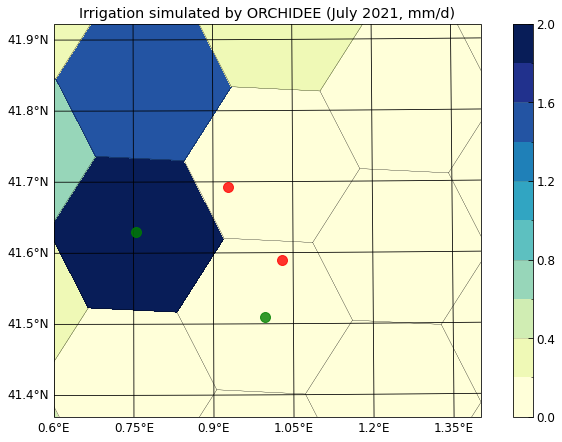

In [47]:
file=orc_irr_1M_newfile
# file=orc_ratios_1M_file
# file=orc_noirr_1M_newfile
# file=orc_noRoughdyn_1M_file
# file=orc_beta1_1M_newfile
# file=orc_routingfull_1M_newfile
# file=orc_routingfull_beta1_1M_newfile
# file=orc_pft13_1M_newfile
var='irrigation'

lat_min, lat_max, lon_min, lon_max = 41.35, 41.82, 0.45, 1.35  
lat_min, lat_max, lon_min, lon_max = 41., 42., 0., 2.  
lat_min, lat_max, lon_min, lon_max = 40., 43., -0.5, 2.5  
# lat_min, lat_max, lon_min, lon_max = 36.0, 44, -10, 3.5  
lat_min, lat_max, lon_min, lon_max = 41.37, 41.92, 0.6, 1.4

vmin=0.
vmax=2
cmap=wet
# (file, var, vmin, vmax, cmap)=(orc_irr_1M_file, 'irrigation', 0, 0.2, wet)

plot_ICO_from_netcdf(file, var, 
                     cmap=cmap,
                     lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max,
                     vmin=vmin, vmax=vmax, 
                     title='Irrigation simulated by ORCHIDEE (July 2021, mm/d)',
    )
ax=plt.gca()
add_liaise_site_loc(ax)

# Time series

## Irr vs No_irr with obs

In [48]:
return()

SyntaxError: 'return' outside function (2760087742.py, line 1)

In [ ]:
var='flat'
orc_var=False
timeslot='sop' 
# timeslot='july'
if timeslot=='sop':
    if orc_var:
        ds1=sop_cen_orc_irr
        ds2=sop_cen_orc_noirr
        ds3=sop_els_orc_irr
        ds4=sop_els_orc_noirr
    else:
        ds2=sop_cen_lmdz_noirr
        ds1=sop_cen_lmdz_irr
        ds3=sop_els_lmdz_irr
        ds4=sop_els_lmdz_noirr
    ds5=sop_cen_mto
    ds6=sop_els_mto
elif timeslot=='july':
    if orc_var:
        ds1=cen_orc_irr
        ds2=cen_orc_noirr
        ds3=els_orc_irr
        ds4=els_orc_noirr
        ds7=cen_orc_noRoughdyn
        ds8=els_orc_noRoughdyn
    else:
        ds2=cen_lmdz_noirr
        ds1=cen_lmdz_irr
        ds3=els_lmdz_irr
        ds4=els_lmdz_noirr
    ds5=cen_mto
    ds6=els_mto

# ds_list=[ds1, ds2]
ds_list=[ds1, ds2, ds5]#, ds7]
# ds_list=[ds1, ds2, ds3, ds4, ds5, ds6]

vmin=950
vmax=1000
vmin, vmax=None, None
# title='{} ({})'.format(var, ds1[var].attrs['units'])
title=None

time_series_ave(ds_list, var, ds_colors=True, 
                # ds_linestyle=True, 
                title=title, vmin=vmin, vmax=vmax)

# vmin, vmax=None, None
# vmin,vmax=0,20
# ds_list=[ds3, ds4]
ds_list=[ds3, ds4, ds6]#, ds8]
# ds_list=[ds4, ds8]
time_series_ave(ds_list, var, ds_colors=True, ds_linestyle=True, title=title, vmin=vmin, vmax=vmax)

In [ ]:
#diurnal cycles
var='t2m'
orc_var=False
# timeslot='sop'
timeslot='july'
if timeslot=='sop':
    if orc_var:
        ds1=sop_cen_orc_irr
        ds2=sop_cen_orc_noirr
        ds3=sop_els_orc_irr
        ds4=sop_els_orc_noirr
    else:
        ds2=sop_cen_lmdz_noirr
        ds1=sop_cen_lmdz_irr
        ds3=sop_els_lmdz_irr
        ds4=sop_els_lmdz_noirr
    ds5=sop_cen_mto
    ds6=sop_els_mto
elif timeslot=='july':
    if orc_var:
        ds1=cen_orc_irr
        ds2=cen_orc_noirr
        ds3=els_orc_irr
        ds4=els_orc_noirr
        # ds7=cen_orc_noRoughdyn
        # ds8=els_orc_noRoughdyn
    else:
        ds2=cen_lmdz_noirr
        ds1=cen_lmdz_irr
        ds3=els_lmdz_irr
        ds4=els_lmdz_noirr
        # ds7=cen_lmdz_noRoughdyn
        # ds8=els_lmdz_noRoughdyn
    ds5=cen_mto
    ds6=els_mto

ds_list=[ds1, ds2, ds5]#, ds7]
# ds_list=[ds1, ds2, ds3, ds4, ds5, ds6]
# ds_list=[ ds2, ds7]

vmin=6.5
vmax=12
vmin, vmax=None, None
title='{} ({})'.format(var, ds1[var].attrs['units'])
# title='Soil temperature 6cm (°C)'

diurnal_cycle_ave(ds_list, var, ds_colors=True, 
                # ds_linestyle=True, 
                title=title, 
                vmin=vmin, vmax=vmax
                )

# vmin, vmax=None, None
# ds_list=[ds3, ds4, ds6]#, ds8]
# # ds_list=[ds4, ds8]
# diurnal_cycle_ave(ds_list, var, ds_colors=True, title=title, 
#                 #   ds_linestyle=True,
#                   vmin=vmin, vmax=vmax
#                   )   

In [ ]:
#plot similar vars in obs to see how they compare
vmin=0
vmax=45
ds=cen_mto
vars=['soil_moisture_1','soil_moisture_2','soil_moisture_3', 'mrsos']
# vars=['mrsos','precip']
plotvars=[ds[var] for var in vars]+[cen_orc_irr['mrsos']]
labels=vars + ['mrsos_ORC_irr']
time_series(plotvars, labels, title='Cendrosa MTO', vmin=vmin, vmax=vmax)

ds=els_mto
vars=['SM02_subsoil','SM10_subsoil','PR10_subsoil','PR20_subsoil']
plotvars=[ds[var] for var in vars]+[els_orc_irr['mrsos']]
labels=vars+ ['mrsos_ORC_irr']
time_series(plotvars, labels, title='Els Plans MTO', vmin=vmin, vmax=vmax)

In [ ]:
#plot similar vars in sim to see how they compare
vars=['SWdnSFC','SWdnSFCclr']
# vars=['SWupSFC','SWupSFCclr']
labels=vars
vmin, vmax=None, None
# vmin=0
# vmax=75

ds=cen_lmdz_irr
plotvars=[ds[var] for var in vars]
# plotvars=[-ds['SWdnSFC']+ds['SWdnSFCclr']]
# labels=['SWdn_clr - SWdn']
time_series(plotvars, labels, title='Cendrosa', vmin=vmin, vmax=vmax)

ds=els_lmdz_irr
plotvars=[ds[var] for var in vars]
# plotvars=[-ds['SWdnSFC']+ds['SWdnSFCclr']]
time_series(plotvars, labels, title='Els Plans', vmin=vmin, vmax=vmax)

## Sensitivity analysis

In [ ]:
timeslot='sop' 
# timeslot='july'
var='sens'
orc_var=False
legend_out=None
obs=True
plot_cendrosa=True
plot_els_plans=True

In [ ]:
#many dataset for sensitivity analysis
if timeslot=='sop':
    ds1=sop_cen_mto
    ds2=sop_els_mto
    if orc_var:
        ds3 =sop_cen_orc_noirr
        ds4 =sop_els_orc_noirr
        ds5 =sop_cen_orc_irr
        ds6 =sop_els_orc_irr
        ds7 =sop_cen_orc_irr100
        ds8 =sop_els_orc_irr100
        ds9 =sop_cen_orc_beta1
        ds10=sop_els_orc_beta1
        ds11=sop_cen_orc_routingfull
        ds12=sop_els_orc_routingfull
        ds13=sop_cen_orc_routingfull_beta1
        ds14=sop_els_orc_routingfull_beta1
        ds15=sop_cen_orc_routingfull_beta15
        ds16=sop_els_orc_routingfull_beta15
        # ds17=sop_cen_orc_routingfull_beta1_dorsoil
        # ds18=sop_els_orc_routingfull_beta1_dorsoil
        # ds19=sop_cen_orc_pft12
        # ds20=sop_els_orc_pft12
        # ds21=sop_cen_orc_pft13
        # ds22=sop_els_orc_pft13
        # ds23=sop_cen_orc_pft12_beta1
        # ds24=sop_els_orc_pft12_beta1
        # ds25=sop_cen_orc_pft12_routingfull_beta1
        # ds26=sop_els_orc_pft12_routingfull_beta1
    else:
        ds3 =sop_cen_lmdz_noirr
        ds4 =sop_els_lmdz_noirr
        ds5 =sop_cen_lmdz_irr
        ds6 =sop_els_lmdz_irr
        ds7 =sop_cen_lmdz_irr100
        ds8 =sop_els_lmdz_irr100
        ds9 =sop_cen_lmdz_beta1
        ds10=sop_els_lmdz_beta1
        ds11=sop_cen_lmdz_routingfull
        ds12=sop_els_lmdz_routingfull
        ds13=sop_cen_lmdz_routingfull_beta1
        ds14=sop_els_lmdz_routingfull_beta1
        ds15=sop_cen_lmdz_routingfull_beta15
        ds16=sop_els_lmdz_routingfull_beta15
        # ds17=sop_cen_lmdz_routingfull_beta1_dorsoil
        # ds18=sop_els_lmdz_routingfull_beta1_dorsoil
        # ds19=sop_cen_lmdz_pft12
        # ds20=sop_els_lmdz_pft12
        # ds21=sop_cen_lmdz_pft13
        # ds22=sop_els_lmdz_pft13
        # ds23=sop_cen_lmdz_pft12_beta1
        # ds24=sop_els_lmdz_pft12_beta1
        # ds25=sop_cen_lmdz_pft12_routingfull_beta1
        # ds26=sop_els_lmdz_pft12_routingfull_beta1
elif timeslot=='july':
    ds1=cen_mto
    ds2=els_mto
    if orc_var:
        ds3  = cen_orc_noirr
        ds4  = els_orc_noirr
        ds5  = cen_orc_irr
        ds6  = els_orc_irr
        ds7  = cen_orc_irr100
        ds8  = els_orc_irr100
        ds9  = cen_orc_beta1
        ds10 = els_orc_beta1
        ds11 = cen_orc_routingfull
        ds12 = els_orc_routingfull
        ds13 = cen_orc_routingfull_beta1
        ds14 = els_orc_routingfull_beta1
        ds15 = cen_orc_routingfull_beta15
        ds16 = els_orc_routingfull_beta15
        # ds17 = cen_orc_routingfull_beta1_dorsoil
        # ds18 = els_orc_routingfull_beta1_dorsoil
        # ds19 = cen_orc_pft12
        # ds20 = els_orc_pft12
        # ds21 = cen_orc_pft13
        # ds22 = els_orc_pft13
        # ds23 = cen_orc_pft12_beta1
        # ds24 = els_orc_pft12_beta1
        # ds25 = cen_orc_pft12_routingfull_beta1
        # ds26 = els_orc_pft12_routingfull_beta1
    else:
        ds3 =cen_lmdz_noirr
        ds4 =els_lmdz_noirr
        ds5 =cen_lmdz_irr
        ds6 =els_lmdz_irr
        ds7 =cen_lmdz_irr100
        ds8 =els_lmdz_irr100
        ds9 =cen_lmdz_beta1
        ds10=els_lmdz_beta1
        ds11=cen_lmdz_routingfull
        ds12=els_lmdz_routingfull
        ds13=cen_lmdz_routingfull_beta1
        ds14=els_lmdz_routingfull_beta1
        ds15=cen_lmdz_routingfull_beta15
        ds16=els_lmdz_routingfull_beta15
        # ds17=cen_lmdz_routingfull_beta1_dorsoil
        # ds18=els_lmdz_routingfull_beta1_dorsoil
        # ds19=cen_lmdz_pft12
        # ds20=els_lmdz_pft12
        # ds21=cen_lmdz_pft13
        # ds22=els_lmdz_pft13
        # ds23=cen_lmdz_pft12_beta1
        # ds24=els_lmdz_pft12_beta1
        # ds25=cen_lmdz_pft12_routingfull_beta1
        # ds26=els_lmdz_pft12_routingfull_beta1

In [ ]:
vmin=-120
vmax=520
# vmin, vmax=None, None
title=var

if plot_cendrosa:
    ds_list_cen=[]
    if var in ds1.variables and obs:
        ds_list_cen=[ds1]
    # ds_list_cen+=[ds3, ds5, ds7, ds9, ds11, ds13, ds15, ds17]
    # ds_list_cen+=[ds7, ds13, ds19, ds25]
    ds_list_cen+=[ds3, ds7, ds13]
    time_series_ave(ds_list_cen, var, ds_colors=True, 
                    # ds_linestyle=True, 
                    title=title, vmin=vmin, vmax=vmax,
                    # figsize=(12,6),
                    legend_out=legend_out
                    )

if plot_els_plans:
    # vmin,vmax=0,15
    # vmin, vmax=None, None
    ds_list_els=[]
    if var in ds2.variables and obs :
        ds_list_els=[ds2]
    ds_list_els+=[ds4, ds8, ds14]#, ds16, ds18]
    time_series_ave(ds_list_els, var, ds_colors=True, ds_linestyle=True, title=title, vmin=vmin, vmax=vmax, legend_out=legend_out)

In [ ]:
vmin=108
vmax=200
vmin, vmax=None, None
title=var

if plot_cendrosa:
    diurnal_cycle_ave(ds_list_cen, var, ds_colors=True, 
                title=title, vmin=vmin, vmax=vmax, 
                legend_out=legend_out)
    
if plot_els_plans:
    diurnal_cycle_ave(ds_list_els, var, ds_colors=True,
                    title=title, vmin=vmin, vmax=vmax,
                    legend_out=legend_out, ds_linestyle=True,)

In [ ]:
return()

# Vertical profiles

In [ ]:
return()
var=''
ds1=iop_els_lmdz_irr['1507']
ds2=iop_els_lmdz_noirr['1507']
ds3=iop_cen_lmdz_irr['1507']
ds4=iop_cen_lmdz_noirr['1507']

ds_list=[ds1, ds2, ds3, ds4]
# ds_list=[ds3, ds4]
ds_list=[ds1]
# ds_list=[cen_lmdz_irr]

# obs_ds_list=[Cendrosa_RS]
obs_ds_list=None

altmax=2000
title=None

# profile_preslevs_local(ds_list, var, title=title, preslevelmax=preslevelmax)
profile_altitude_local_mean(ds_list, var, title=title, altmax=altmax,
                            obs_ds_list=obs_ds_list,
                            nbins=None,
                            substract_gl=True,
                            )

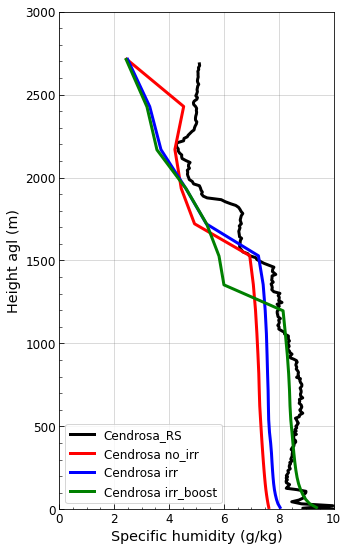

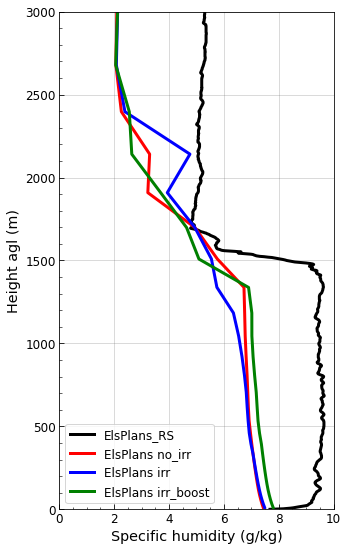

In [75]:
profiles_cendrosa=True
profiles_elsplans=True

day='2007'
ds1=iop_cen_lmdz_noirr
ds2=iop_cen_lmdz_irr
ds3=iop_cen_lmdz_routingfull_beta1

ds4=iop_els_lmdz_noirr
ds5=iop_els_lmdz_irr
ds6=iop_els_lmdz_routingfull_beta1

# times=[5.25,9.25,13.25, 17.25]
times=[12.25]

var='temp'
# xmin, xmax = None, None
xlabel=None

# var, xmin, xmax = 'theta', 300, 320
var, xmin, xmax, xlabel = 'theta', 305, 312, 'Potential temperature (K)'
# var, xmin, xmax = 'ovap', 0, 14
var, xmin, xmax, xlabel = 'ovap', 0, 10, 'Specific humidity (g/kg)'
# var, xmin, xmax = 'wind_speed', 0, 12
# var, xmin, xmax = 'wind_direction', 0, 360
altmax=3000
title='Potential temperature (K)'

if profiles_cendrosa:
    ds_list, obs_dict=[ds1[day], ds2[day], ds3[day]], cen_RS[day]
    profile_altitude_multipletimes_obs(ds_list, obs_dict, var, times, 
                                    # title=title, 
                                    altmax=altmax, xmin=xmin, xmax=xmax, 
                                    # nbins=5,
                                    substract_gl=True,
                                    simfreq='30mn',
                                    xlabel=xlabel,
                                    ylabel=False
                                    )

if profiles_elsplans:
    ds_list, obs_dict=[ds4[day], ds5[day], ds6[day]], els_RS[day]
    # ds_list, obs_dict=[iop_els_lmdz_noirr[day]], els_RS[day]
    profile_altitude_multipletimes_obs(ds_list, obs_dict, var, times, 
                                    # title=title, 
                                    altmax=altmax, xmin=xmin, xmax=xmax, 
                                    # nbins=5,
                                    substract_gl=True,
                                    simfreq='30mn',
                                    xlabel=xlabel,
                                    ylabel=False
                                    )

In [ ]:
profiles_cendrosa=True
profiles_elsplans=False

ds1=iop_cen_lmdz_noirr
ds2=iop_cen_lmdz_irr
ds3=iop_cen_lmdz_routingfull_beta1

ds4=iop_els_lmdz_noirr
ds5=iop_els_lmdz_irr
ds6=iop_els_lmdz_routingfull_beta1

# daylist=['1507']

# times=[5.25,9.25,13.25,17.25]

# var='theta'
# xmin, xmax = None, None

var, xmin, xmax = 'theta', 290, 314
# var, xmin, xmax = 'theta', 295, 310
# var, xmin, xmax = 'ovap', 2, 14
# var, xmin, xmax = 'ovap', 3.5, 10
# var, xmin, xmax = 'wind_speed', 0, 10
# var, xmin, xmax = 'wind_direction', 0, 360

altmax=3000

if profiles_cendrosa:
    i=0
    for day in RS_days_list:
        title=nice_day_print[day]
        times_ref=cen_times_list[i]
        times = [t+0.25 for t in times_ref]
        print('day:', day, 'times:', times)
        i+=1
        ds_list =[ds1[day], ds2[day], ds3[day]]
        # ds_list = []
        obs_dict = cen_RS[day]
        # ([6.25,9.25,13.25, 17.25] if day=='1507' else 
        profile_altitude_multipletimes_obs(ds_list, obs_dict, var, times, 
                                        altmax=altmax, xmin=xmin, xmax=xmax, 
                                        # nbins=5,
                                        substract_gl=True,
                                        # substract_gl=False,
                                        # altsite=Cendrosa_altitude,
                                        simfreq='30mn', 
                                        title='{} at La Cendrosa'.format(title)
                                        )
        fig_name='figures/rs_iop_liaise/cendrosa/rs_{}_Cendrosa_{}'.format(var,day)
        plt.savefig(fig_name)

if profiles_elsplans:
    i=0
    for day in RS_days_list:
        title=nice_day_print[day]
        times_ref=els_times_list[i]
        times = [t+0.25 for t in times_ref]

        ds_list =[ds4[day], ds5[day], ds6[day]]
        # ds_list, obs_dict=[ds2[day]], 
        obs_dict = els_RS[day]
        profile_altitude_multipletimes_obs(ds_list, obs_dict, var, times, 
                                        altmax=altmax, xmin=xmin, xmax=xmax, 
                                        # nbins=5,
                                        substract_gl=True,
                                        # substract_gl=False,
                                        # altsite=ElsPlans_altitude,
                                        simfreq='30mn',
                                        title='{} at Els Plans'.format(title)
                                        )
        fig_name='figures/rs_iop_liaise/elsplans/rs_{}_ElsPlans_{}'.format(var,day)
        plt.savefig(fig_name)

# Site caracterization

In [ ]:
els_lmdz_irr['aire'].values

In [ ]:
cen_orc_irr_1M, els_orc_irr_1M = select_liaise_sites_sop(orc_irr_1M, 'irr', sop=False)
cen_orc_noirr_1M, els_orc_noirr_1M = select_liaise_sites_sop(orc_noirr_1M, 'no_irr', sop=False)
# cen_orc_irr_1M

In [ ]:
cen_lmdz_irr_1M, els_lmdz_irr_1M = select_liaise_sites_sop(lmdz_irr_1M, 'irr', sop=False)
cen_lmdz_noirr_1M, els_lmdz_noirr_1M = select_liaise_sites_sop(lmdz_noirr_1M, 'no_irr', sop=False)
# cen_lmdz_irr_1M

In [ ]:
els_lmdz_irr_1M['bounds_lon'].values

In [ ]:
els_lmdz_irr_1M['bounds_lat'].values

In [ ]:
def round_value(val):
    if isinstance(val, xr.DataArray):
        return round(float(val.values), 1)
    elif isinstance(val, (int, float)):
        return round(val, 2)
    return val

In [ ]:
def process_list(input_list):
    print( [round(x * 100, 1) for x in input_list])

In [ ]:
ds=cen_orc_routingfull_beta1_dorsoil_1M
process_list(ds['soiltile'].values)
process_list(ds['maxvegetfrac'].values[0])
process_list(ds['vegetfrac'].values[0])

In [ ]:
ds=cen_orc_routingfull_beta1_1M
process_list(ds['soiltile'].values)
process_list(ds['maxvegetfrac'].values[0])
process_list(ds['vegetfrac'].values[0])

In [ ]:
ds=cen_orc_routingfull_1M
ds=cen_orc_routingfull_beta1_1M
ds=cen_orc_routingfull_beta1_dorsoil_1M
ds=cen_orc_pft12_routingfull_beta1_1M
process_list(ds['vegetfrac'].values[0])

In [ ]:
orc_varlist=['tot_bare_soil', 'LAImean', 'albedo_glob',
             'irrigmap_dyn','irrig_frac', 'aei_sw', 'root_deficit', 'netirrig','irrigation',
             'mrsos', 'temp_sol', 'rain']
# orc_ds_list=[cen_orc_irr_1M, els_orc_irr_1M, cen_orc_routingfull_1M ]#cen_orc_maps_irr_1M, els_orc_maps_irr_1M]
# orc_ds_list=[cen_orc_irr100_1M,  cen_orc_routingfull_beta1_1M, cen_orc_routingfull_beta1_dorsoil_1M]#, els_orc_routingfull_beta1_1M]#cen_orc_maps_irr_1M, els_orc_maps_irr_1M]
# orc_ds_list=[cen_orc_irr100_1M, cen_orc_routingfull_beta1_1M, cen_orc_pft12_1M, cen_orc_pft12_routingfull_beta1_1M]#, ]#cen_orc_maps_irr_1M, els_orc_maps_irr_1M]
orc_ds_list=[els_orc_irr_1M, els_orc_irr100_1M, els_orc_routingfull_beta1_1M]

rows = []
for ds in orc_ds_list:
    row_data = {}
    for var in orc_varlist:
        row_data[var] = ds[var].values[0]
    rows.append(row_data)

df = pd.DataFrame(rows)
# df=df.round(2)
df.index = [ds.attrs['name'] for ds in orc_ds_list]

df

In [ ]:
lmdz_varlist=['ground_level','psol','t2m','flat', 'sens',
               'SWdnSFC', 'LWdnSFC', 'SWupSFC', 'LWupSFC']
# lmdz_ds_list=[cen_lmdz_irr100_1M, cen_lmdz_pft12_1M]
lmdz_ds_list=[cen_lmdz_irr100_1M, cen_lmdz_routingfull_beta1_1M, cen_lmdz_routingfull_beta1_dorsoil_1M]#, els_lmdz_routingfull_beta1_1M]#cen_lmdz_maps_irr_1M, els_lmdz_maps_irr_1M]
lmdz_ds_list=[cen_lmdz_irr100_1M, cen_lmdz_routingfull_beta1_1M, cen_lmdz_pft12_1M, cen_lmdz_pft12_routingfull_beta1_1M]#, els_lmdz_routingfull_beta1_1M]#cen_lmdz_maps_irr_1M, els_lmdz_maps_irr_1M]


rows = []
for ds in lmdz_ds_list:
    row_data = {}
    for var in lmdz_varlist:
        row_data[var] = round(ds[var].values[0],1)
        # print (var, row_data[var])
    rows.append(row_data)

df = pd.DataFrame(rows)
df = df.map(round_value)
df.index = [ds.attrs['name'] for ds in lmdz_ds_list]

df